# Analysis for spine shape and density
> need prepare some material
1. singe frame image
2. its label(annotation) file , value 0: background ,1:dendrite,>1 spine
> output (need specify output folder)
1. density for each branch, if each dendrite branch are marked by different ID(color)
2. spine volume/area, mean itensity,length, neck width, head width, shape(by previous characters' ratio)
3. the crop images for spines, named like -XXXID-mask.tif". The unattached spines will be reattached to dendrite

In [19]:
#=======================#
#   import module  #
#=======================#
# %matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from scipy import ndimage
from skimage.io import imsave
from skimage.morphology import remove_small_objects
from skimage.segmentation import expand_labels, watershed

InteractiveShell.ast_node_interactivity = 'last_expr'

import pandas as pd

sys.path.append("..")
sys.path.append("..//..")
from spinelib import cflow, imgio, seg
from spinelib.imgio.imgio_base import savelabel, savepr
from spinelib.utils import measure
from spinelib.utils.spine_struct import spines_distance
from utils import file_base

shape_kvs={0:"unkownn",1:"stubby",2:"mushroom",3:"thin"}
shape_rkvs={"unkownn":0,"stubby":1,"mushroom":2,"thin":3}


# save csv
# row : id,[centroid-z,],centeroid/x,centerid/y,area/volume,mean intensity,length,head-diameter,perimeter/suface/area,rotate-mask

#=======================#
#   paras setting  #
#=======================#
searchbox=[8,20,20] # 3D like [3,20,20], search box specify search radius,exactly size= 2*radius+1

#=======================#
#   load setting  #
#=======================#
#image
filename=r"F:\data\dataset\myspine-dataset2\2D-morph-seg\img\Stablized tboa 20180128n1-1.tif"
#annotation file(include dendrite)
spinefile=r"F:\data\dataset\myspine-dataset2\2D-morph-seg\label\Stablized tboa 20180128n1-1-seg.tif"



#=======================#
#   save setting  #
#=======================#
# result folder
savedir=r"F:\data\dataset\myspine-dataset2\classification\temp"
file_base.create_dir(savedir)
ddir,shortname,suffix=file_base.split_filename(filename)
savedir=os.path.join(savedir,shortname)
file_base.create_dir(savedir)
# result file
# areafile=r"D:\data\Train\test\0319-result\0319-info.csv"
areafile=os.path.join(savedir,shortname+"_info.csv")
skeletonfile=os.path.join(savedir,shortname+"-skeleton.tif")
stodenfile=os.path.join(savedir,shortname+"-trace.tif")
denfile=os.path.join(savedir,shortname+"-branch-den.tif")




#=======================#
#   Running  #
#=======================#
# create folder and load data
file_base.create_dir(savedir)
img=imgio.ski_imread(filename)
spine_label=imgio.ski_imread(spinefile)
ndim=img.ndim

create dir :  F:\data\dataset\myspine-dataset2\classification\temp\Stablized tboa 20180128n1-1


## Shape

In [3]:
# length and head and individual rotate-mask
lables_dict=measure.label_statics(img,spine_label)
from csbdeep.utils import normalize
from skimage.filters import gaussian
corddict,linemask=spines_distance(img,spine_label,searchbox=[40,40],imgweight=1,useO2=False,rotatef=True)
# centroid,traces,length,headlength,mask=
# cords : dict[lab] = (centroid , path from den to spine bound),length,headlength,spinemask
# savelabel(spine_label,spinefile)
labs=set(np.unique(spine_label))
i=0
for lab in labs:
    i+=1
    # if i>20: break
    if lab==1: continue
    if lab not in corddict: continue
    cords,length,headlength,attach_cnt,rotamask,rotaimg,rotaden=corddict[lab]
    lables_dict[lab].append(length)
    lables_dict[lab].append(headlength)
    lables_dict[lab].append(attach_cnt)
    if rotamask is None: continue
    # check shape type
    v=0 # unkown type ,1:stubby ,2:mushroom,3:thin
    LL=length/attach_cnt
    LH=headlength/attach_cnt
    if LL<1.8: 
        if LH<2:
            v=1 #s
        elif LH<2:
            v=2 #m
        else:
            v=1
    elif LL<5:
        if LL/LH>3:
            v= 3# t
        else:
            v=2
    elif LL<10:
        if LL/LH>3.5:
            v=3
        else:
            v=2 
    else:
        if LL/LH>3.5:
            v=3
        else:
            v=2 
        
    lables_dict[lab].append(shape_kvs[v])
    normimg=normalize(rotaimg.astype("float32"))
    normlab=normalize(gaussian(rotamask)*normimg)
    normden=normalize(gaussian(rotaden)*normimg)
    # print(normimg.shape,normlab.shape)
    #normall=np.array([normimg,rotamask,normlab,normden])
    # normall=np.array([normlab,normden])
    normall=np.array([normlab,normden,normimg])
    #normall=np.transpose(normall,(1,2,0))
    #savepr(normall,os.path.join(savedir,shortname+str(lab)+"-ID-norm.tif"))
    #imsave(os.path.join(savedir,shortname+str(lab)+"-ID-norm.tif"),normall)
    # savelabel(rotamask,os.path.join(savedir,str(lab)+"-ID-mask.tif"))
    # savelabel(rotaimg,os.path.join(savedir,str(lab)+"-ID-img.tif"))
    #savelabel(rotamask,os.path.join(savedir,str(lab)+"-ID-mask.tif"))

df=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in lables_dict.items()]))

if ndim==3:
    df.rename(columns={0:'bg',1:'den'},index={0:"centroidz",1:"centroidy",2:"centroidx",3:"Area/Volume",4:"mean-intensity",5:"length",6:"headlength",7:"attach-den",8:"shape"},inplace=True)
else:   
    df.rename(columns={0:'bg',1:'den'},index={0:"centroidy",1:"centroidx",2:"Area/Volume",3:"mean-intensity",4:"length",5:"headlength",6:"attach-den",7:"shape"},inplace=True)

#=======================#
#   Save result  #
#=======================#
df.to_csv(areafile)
savelabel(linemask,stodenfile)
print("save :",areafile)


save : F:\data\dataset\myspine-dataset2\classification\temp\Stablized tboaltp20180128n3-1\Stablized tboaltp20180128n3-1-trace.tif
save : F:\data\dataset\myspine-dataset2\classification\temp\Stablized tboaltp20180128n3-1\Stablized tboaltp20180128n3-1_info.csv


C:\Users\ZLY\AppData\Local\Temp\ipykernel_32056\1452309134.py:63: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in lables_dict.items()]))


## density

In [6]:
from skimage.morphology import skeletonize_3d
import scipy.ndimage as ndi
from skimage import morphology

#------skeleton-------------
den=skeletonize_3d(spine_label==1)
den=den>0
structure=np.ones((5,)*ndim)
den=morphology.binary_dilation(den,structure)
den=den=skeletonize_3d(den)
den=den>0
# need correction skeleton in viewer
viewer=imgio.plot.imshow3d(img,label_lay=[den],
                           label_lay_name=["den"],
                                 )

den=viewer.layers["den"].data

In [75]:
viewer=imgio.plot.imshow3d(img,label_lay=[den],
                           label_lay_name=["den"],)

NameError: name 'den' is not defined

In [10]:
# remark skeleton------------

def removenode(skeleton,connection):
    for i in range(1,skeleton.shape[0]-1):
        for j in range(1,skeleton.shape[1]-1):
            if cflow.skeleton_leaf.get_border_connection(skeleton,i,j)>=connection:
                skeleton[i,j]=0
# den=den>0
removenode(den,3)
den,_=ndi.label(den,np.ones((3,)*ndim))
viewer=imgio.plot.imshow3d(img,label_lay=[den],
                           label_lay_name=["den"],
                                 )
den=viewer.layers["den"].data

In [18]:
#---  segment dendrite to different branchs
denmask=watershed(-img,den,mask=spine_label==1)
viewer=imgio.plot.imshow3d(img,label_lay=[den,denmask],
                           label_lay_name=["den","denmask"],
                                 )
savelabel(denmask,denfile)
savelabel(den,skeletonfile)

In [21]:

denmask=imgio.ski_imread(denfile)
den=imgio.ski_imread(skeletonfile)
# caculate dendity
import collections
import spinelib
cnts=collections.defaultdict(int)
labs=set(np.unique(spine_label))
i=0
for lab in labs:
    i+=1
    # if i>20: break
    if lab==1: continue
    if lab not in corddict: continue
    cords,length,headlength,attach_cnt,rotamask=corddict[lab]
    if rotamask is None: continue
    x,y=cords[1]
    cnts[denmask[x,y]]+=1 


dlabels=measure.label_statics(img,den)

 
#create DataFrame
df2 = pd.DataFrame(columns=["branch","length","number","density"])

for lab,area in dlabels.items():
    if area:
        area=area[2]
        df2.loc[lab]=[lab,area*0.16,cnts[lab],cnts[lab]/area/0.16]
        print(lab,area*0.16,cnts[lab],cnts[lab]/area/0.16)
df2

1 28.32 27 0.9533898305084746
2 45.44 24 0.528169014084507
3 49.120000000000005 42 0.8550488599348535
4 57.6 48 0.8333333333333333
5 52.32 22 0.4204892966360856


,branch,length,number,density
1,1.0,28.32,27.0,0.953390
2,2.0,45.44,24.0,0.528169
3,3.0,49.12,42.0,0.855049
4,4.0,57.60,48.0,0.833333
5,5.0,52.32,22.0,0.420489


## visualization

In [17]:
# plot images scattet plot


figsize=(10,10)
fontsize=20
radm=60
resolution=0.16
def plot_scatter(x,y,z,c,s): # c color ,s size
    fig = plt.figure(figsize = figsize)  
    ax = plt.axes()  
    # Creating a plot using the random datasets   
    ax.set_xlabel('length /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head /μm', fontweight ='normal',fontsize=fontsize)  
    # ax.set_zlabel('attach', fontweight ='bold') 
    cmap=plt.get_cmap('viridis')
    cmap=plt.get_cmap('Set2')
    # cmap=plt.cm.Spectral
    # print(x.shape,y.shape,z.shape)
    # z=np.array(z).ravel()
    # norm = plt.Normalize(vmin=np.nanmin(z)-1, vmax=np.nanmax(z)-1)
    # vmax=np.nanmax(z)
    # alpha=norm(z)
    # alpha[np.isnan(alpha)]=0
    norm = plt.Normalize(vmin=np.nanmin(s)-resolution, vmax=np.nanmax(s)-resolution)
    # s=30*(vmax-z)
    # x=x[~ np.isnan(x)]
    # y=y[~ np.isnan(y)]
    # z=z[~ np.isnan(z)]
    sctt=ax.scatter(x, y, c=c,cmap=cmap,alpha=0.8,vmin=0,vmax=5)  
    # cbar=fig.colorbar(sctt, ax = ax, shrink = 0.6, aspect = 5)
    # cbar.ax.set_title('neck/μm',fontsize=fontsize)
    # ax.set_xlim(0,4)
    # ax.set_ylim(0,2.5)
    xlables=ax.get_xticks()
    ylables=ax.get_yticks()
    ax.set_xticklabels(xlables,fontsize=15)
    ax.set_yticklabels(ylables,fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("2D scatter") 
def plot_scatter3D(x,y,z,c,s):
    fig = plt.figure(figsize = figsize)  
    ax = plt.axes(projection ="3d")  
    # Creating a plot using the random datasets   
    ax.set_xlabel('length /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head /μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_zlabel('neck /μm', fontweight ='normal',fontsize=fontsize) 
    
    cmap=plt.get_cmap('viridis')
    cmap=plt.get_cmap('Set2')
    # cmap=plt.cm.Spectral
    print(x.shape,y.shape,z.shape)
    # norm = plt.Normalize(vmin=np.min(z), vmax=np.max(z))
    norm = plt.Normalize(vmin=np.nanmin(s)-1, vmax=np.nanmax(s)-1)
    sctt=ax.scatter3D(x, y, z,c=c,cmap=cmap,vmin=0,vmax=5,alpha=0.8)  
    cbar=fig.colorbar(sctt, ax = ax, shrink = 0.6, aspect = 5)
    cbar.ax.set_title('type',fontsize=fontsize)
    # plt.tight_layout(pad=3,rect=[0.1,0.8,0.1,0.8])
    plt.title("3D scatter plot")
def plot_images_at_cords(images,oys,oxs,ozs,cs,labs,maxsize,zoom=1.0):
    # if maxsize smaller than any images, 
    # remove nan
    xs=oxs[~ np.isnan(oxs)]
    ys=oys[~ np.isnan(oys)]
    zs=ozs[~ np.isnan(ozs)]
    zs=np.sort(np.unique(zs))
    xs=np.sort(np.unique(xs))#/zs[0]
    # print(xs)
    ys=np.sort(np.unique(ys))#/zs[0]
    min_spacex=np.min(xs[1:]-xs[0:-1]) 
    min_spacex=max(min_spacex,0.1) 
    min_spacey=np.min(ys[1:]-ys[0:-1])
    min_spacey=max(min_spacey,0.1) 
    xlim=[xs[0],xs[-1]]
    ylim=[ys[0],ys[-1]]
    ratiox=maxsize[0]/min_spacex
    ratioy=maxsize[1]/min_spacey
    print(min_spacex,min_spacey,xlim,ylim)
    canvassize=[maxsize[0]*int((xlim[1]-xlim[0])/min_spacex+3),
                maxsize[1]*int((ylim[1]-ylim[0])/min_spacey+3)]
    canvas=np.ones(canvassize)*np.nan
    cnts={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
    nms={}
    for im,x,y,z,c,lab in zip(images,oxs,oys,ozs,cs,labs):
        if np.isnan(x) or np.isnan(y) or im is None:
            continue
        # x=x/z
        # y=y/z
        c=c+1
        cropcanvas=np.zeros_like(maxsize)-1
        # check imagesize
        im=np.array(im>0,dtype="float")
                
        nms[lab]=c
        im[im>0]=c
        im[im==0]=np.nan
        # cnts[c]+=1
        # im=ndimage.zoom(im,zoom)
        imshape=im.shape
        x=xlim[1]-x
        y=y-ylim[0]
        bx=int(x*ratiox-imshape[0]/2)+maxsize[0]
        by=int(y*ratioy-imshape[1]/2)+maxsize[1]
        if np.isnan(canvas[bx:bx+imshape[0],by:by+imshape[1]]).all(): 
            canvas[bx:bx+imshape[0],by:by+imshape[1]][im>0]=im[im>0]
    print("uni",np.unique(canvas),cnts)
    fig = plt.figure(figsize =figsize) 
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    imm=ax.imshow(canvas,cmap="Set2",vmin=1,vmax=6,interpolation='none',interpolation_stage="rgba")
    # imm=ax.imshow(canvas,interpolation='nearest',interpolation_stage="rgba")
    cbar=fig.colorbar(imm, ax = ax, shrink = 0.6, aspect = 5)
    cbar.ax.set_title('neck /μm', fontweight ='normal',fontsize=fontsize)
    # xlables=ax.get_xticks()
    # ylables=ax.get_yticks()
    # ax.set_xticklabels([round((y-maxsize[1])/ratioy+ylim[0],2) for y in xlables],fontsize=15)
    # ax.set_yticklabels([round(xlim[1]-(x-maxsize[0])/ratiox,2) for x in ylables],fontsize=15)
    def lin(a1,a2,b1,b2):
        k=(b2-b1)/(a2-a1)
        i=b1-a1*k
        def func(x):
            return k*x+i
        return func
    xfunc=lin(xs[0],xs[-1],canvas.shape[0]-1.5*maxsize[0],0)
    print([round(i*ratiox,0) for i in np.arange(0,3,0.5)])
    ax.set_yticks([round(xfunc(i),0) for i in np.arange(0,3.5,0.5)])
    ax.set_xticks([round((i-ys[0])*ratioy+maxsize[0],0) for i in np.arange(0,4.5,0.5)])
    ax.set_yticklabels(np.arange(0,3.5,0.5),fontsize=15)
    ax.set_xticklabels(np.arange(0,4.5,0.5),fontsize=15)
    ax.set_xlabel('length/μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_ylabel('head/μm', fontweight ='normal',fontsize=fontsize)  
    ax.set_xlim(0,400)
    ax.set_ylim(300,-25)
    print()
    return nms
      
        
    

0.11199999999999988 0.1599999999999997 [0.11199999999999999, 1.3439999999999999] [0.32, 4.96]
uni [ 2.  3.  4. nan] {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
[0.0, 89.0, 179.0, 268.0, 357.0, 446.0]

(156,) (156,) (156,)


C:\Users\ZLY\AppData\Local\Temp\ipykernel_32056\131507303.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlables,fontsize=15)
C:\Users\ZLY\AppData\Local\Temp\ipykernel_32056\131507303.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylables,fontsize=15)


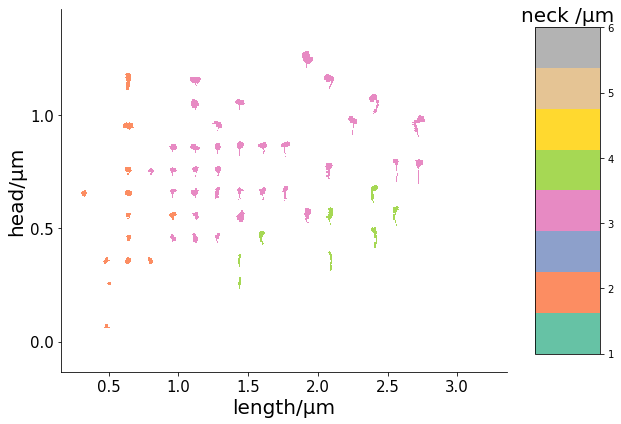

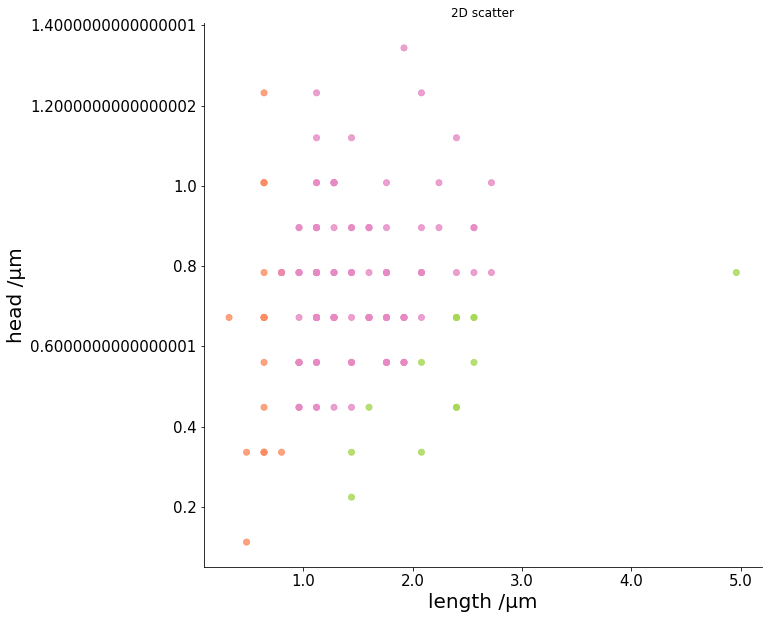

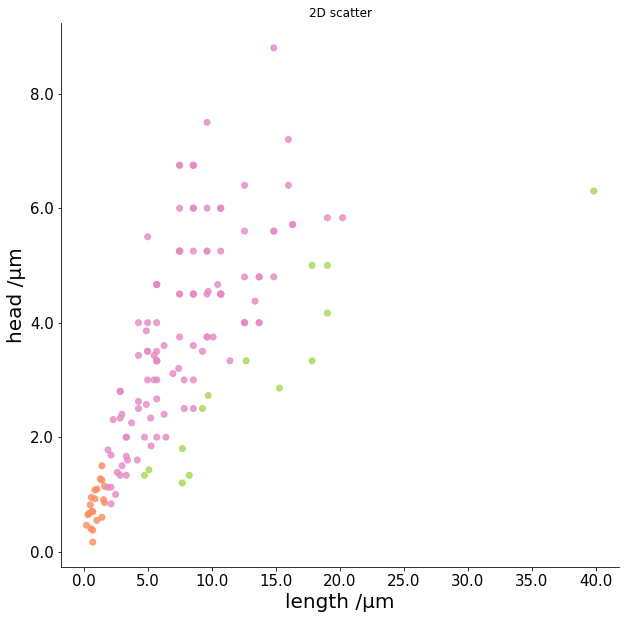

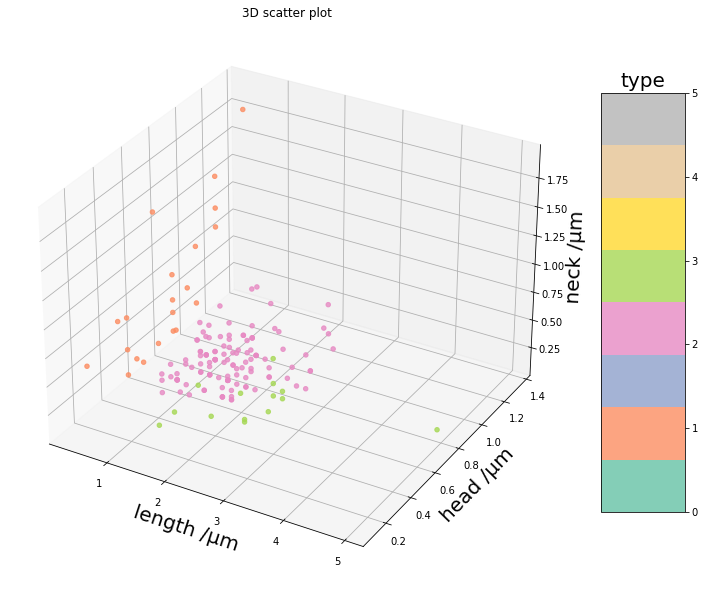

In [18]:
di=ndim-2
A=df.iloc[[2+di],2:]*0.16*0.16
x=df.iloc[[4+di],2:]*0.16
y=df.iloc[[5+di],2:]*0.16
z=df.iloc[[6+di],2:]*0.16
w=df.iloc[[7+di],2:]
w=[shape_rkvs[zz] if zz in shape_rkvs  else 0 for zz in w.values[0]]
A=np.array(A).ravel()
x=np.array(x,dtype="float").ravel()
y=np.array(y,dtype="float").ravel()
z=np.array(z,dtype="float").ravel()
labs=np.array(df.columns[2:]).ravel()
ms=[corddict[lab][-3] if lab in corddict else None for lab in labs]
inds=[i for i in range(x.shape[0]) if ~np.isnan(x[i])]
mss=[ms[i] for i in inds]
ws=[w[i] for i in inds]
labs=labs[~ np.isnan(x)]
As=A[~ np.isnan(x)]
xs=x[~ np.isnan(x)]
ys=y[~ np.isnan(y)]
zs=z[~ np.isnan(z)]
# nms=plot_images_at_cords(mss,xs,ys,zs,zs,labs,[20,20],zoom=1.0) 
nms=plot_images_at_cords(mss,xs,ys,zs,ws,labs,[20,20],zoom=1.0) 
plot_scatter(x,y,z,ws,s=A)
plot_scatter(x/z,y/z,z,ws,s=A)
%matplotlib inline 
plot_scatter3D(x,y,z,w,s=A)
plt.tight_layout()

(154,) (154,) (154,)


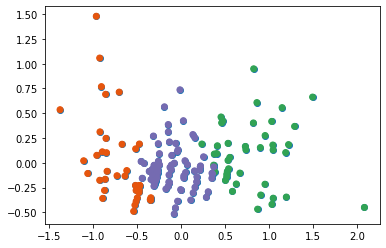

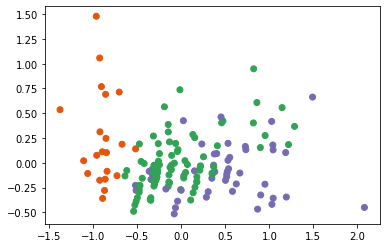

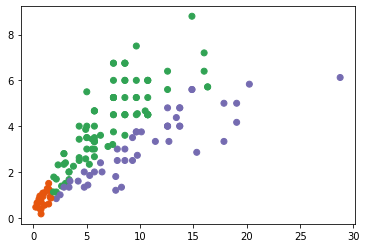

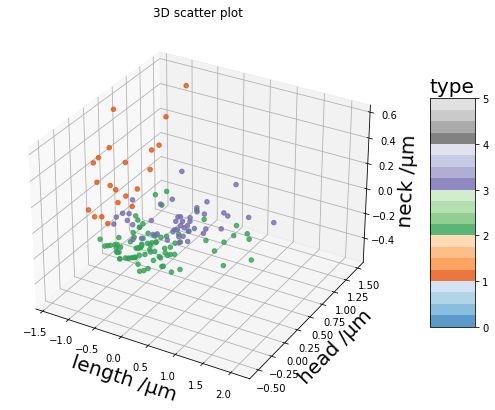

In [9]:
import numpy as np
from sklearn.decomposition import PCA,NMF
from sklearn.manifold import TSNE
from sklearn import cluster, datasets, mixture
X = np.array(list(zip(xs,ys,zs,As)))
X.shape

pca = PCA(n_components=3)
X_r = pca.fit_transform(X)
plt.scatter(
        X_r[:, 0], X_r[:, 1], 
    )
# plt.scatter(
#         xs, ys, 
#     )
spectral = cluster.SpectralClustering(
        n_clusters=3,
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
spectral.fit(X_r)
y_pred = spectral.labels_.astype(int)+1
labs
plt.scatter(
        X_r[:, 0], X_r[:, 1], c=y_pred,cmap="tab20c",vmin=0,vmax=5
    )
plt.figure()
plt.scatter(
        X_r[:, 0], X_r[:, 1],  c=ws,cmap="tab20c",vmin=0,vmax=5
    )
plt.figure()
plt.scatter(
        xs/zs,ys/zs,  c=ws,cmap="tab20c",vmin=0,vmax=5
    )
plot_scatter3D(X_r[:, 0], X_r[:, 1],X_r[:, 2],ws,s=ws)
plt.show()

In [18]:
from spinelib import cflow, imgio, seg
from skimage.morphology import binary_dilation, convex_hull_image, dilation,binary_erosion

spine_label_c=np.zeros_like(spine_label)
for k,v in nms.items():
    spine_label_c[(spine_label==k)>binary_dilation(spine_label_c>0)]=v
    spine_label_c[linemask==k]=v

viewer=imgio.plot.imshow3d(I=img,
    label_lay=[spine_label_c,spine_label],
    label_lay_name=["mask","label","D"]   )